In [45]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import tensorflow as tf
from tensorflow import keras

# 1). Q-Learning.

In [33]:
# Función para elegir la acción con una política epsilon-greedy
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1])
    else:
        return np.argmax(Q[state])

In [34]:
# Función para actualizar la tabla Q
def update_q_table(Q, state, action, reward, next_state, alpha, gamma):
    best_next_action = np.argmax(Q[next_state])  # Mejor acción futura basada en la tabla Q actual
    td_target = reward + gamma * Q[next_state][best_next_action]
    td_error = td_target - Q[state][action]
    Q[state][action] += alpha * td_error

In [35]:
def train_q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []

    for i_episode in range(num_episodes):
        state = env.reset()[0]  # Solo tomar la primera parte de la tupla, ignorando el diccionario vacío.
        total_reward = 0
        done = False

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state, reward, done, _ = env.step(action)  # Ajustar según la estructura de la salida
            next_state = next_state[0]  # Si el estado se devuelve dentro de una tupla anidada
            update_q_table(Q, state, action, reward, next_state, alpha, gamma)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        if (i_episode + 1) % 1000 == 0:
            print(f"Episode {i_episode + 1}: Average Reward = {np.mean(rewards[-1000:])}")

    return Q, rewards

In [36]:
# Función para entrenar usando Q-learning con análisis de convergencia
def train_q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []
    max_td_errors = []  # Para análisis de convergencia

    for i_episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0
        done = False
        max_td_error = 0  # Máximo error TD en este episodio

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state, reward, done, _, _ = env.step(action)  # Ajustar según la estructura de la salida
            next_state = next_state[0]  # Si el estado se devuelve dentro de una tupla anidada

            old_value = Q[state][action]  # Valor antes de actualizar
            update_q_table(Q, state, action, reward, next_state, alpha, gamma)
            td_error = abs(old_value - Q[state][action])
            max_td_error = max(max_td_error, td_error)

            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        max_td_errors.append(max_td_error)  # Registrar el máximo error TD

        if (i_episode + 1) % 1000 == 0:
            print(f"Episode {i_episode + 1}: Average Reward = {np.mean(rewards[-1000:])}")

    return Q, rewards, max_td_errors

In [37]:
# Parámetros
env = gym.make('Blackjack-v1')
num_episodes = 500000
alpha = 0.1
gamma = 0.99
epsilon = 0.1

# Entrenamiento
Q, rewards3, max_td_errors3 = train_q_learning(env, num_episodes, alpha, gamma, epsilon)

c:\Users\gonza\anaconda3\envs\RL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1000: Average Reward = -0.155
Episode 2000: Average Reward = -0.146
Episode 3000: Average Reward = -0.182
Episode 4000: Average Reward = -0.179
Episode 5000: Average Reward = -0.188
Episode 6000: Average Reward = -0.128
Episode 7000: Average Reward = -0.176
Episode 8000: Average Reward = -0.159
Episode 9000: Average Reward = -0.167
Episode 10000: Average Reward = -0.199
Episode 11000: Average Reward = -0.126
Episode 12000: Average Reward = -0.146
Episode 13000: Average Reward = -0.13
Episode 14000: Average Reward = -0.086
Episode 15000: Average Reward = -0.152
Episode 16000: Average Reward = -0.144
Episode 17000: Average Reward = -0.063
Episode 18000: Average Reward = -0.135
Episode 19000: Average Reward = -0.194
Episode 20000: Average Reward = -0.148
Episode 21000: Average Reward = -0.166
Episode 22000: Average Reward = -0.148
Episode 23000: Average Reward = -0.125
Episode 24000: Average Reward = -0.156
Episode 25000: Average Reward = -0.17
Episode 26000: Average Reward = -0.1

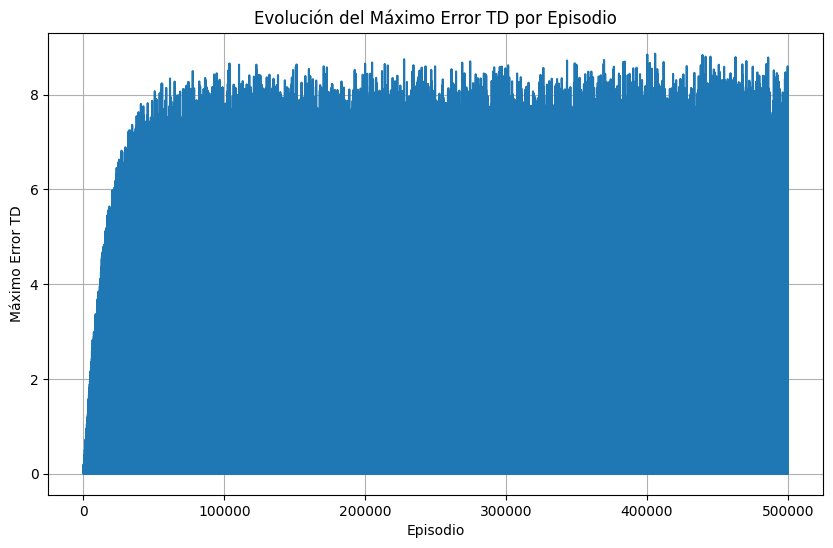

In [36]:
# Gráfico de la convergencia
plt.figure(figsize=(10, 6))
plt.plot(max_td_errors)
plt.xlabel('Episodio')
plt.ylabel('Máximo Error TD')
plt.title('Evolución del Máximo Error TD por Episodio')
plt.grid(True)
plt.show()

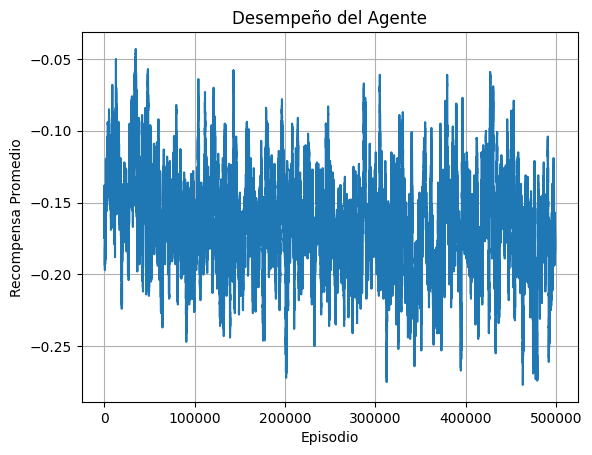

In [38]:
# Visualización de los resultados
plt.plot(np.convolve(rewards, np.ones(1000)/1000, mode='valid'))
plt.title('Desempeño del Agente')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Promedio')
plt.grid(True)
plt.show()

La recompensa media de ningun episodio supere el valor de 0. En promedio el agente ha perdido. Esto no es inesperado. El Blackjack, como se juega en los casinos, es un juego con expectativa negativa para el jugador. Esto significa que, en promedio y sobre muchos juegos, se espera que el casino (o el crupier) gane. Por lo tanto, un agente que aprende a jugar Blackjack se enfrentará a este mismo desafío inherente al juego.

La recompensa promedio no está muy por debajo de cero, lo que podría sugerir que el agente ha aprendido una estrategia razonable que minimiza pérdidas en lugar de ganar constantemente, lo cual es realista para un juego como el Blackjack.

La variabilidad no parece disminuir significativamente con el tiempo, lo que podría sugerir que el agente aún podría mejorar su estrategia.

# 2). Deep Reinforcement Learning (Double Q-Network). 

### DQN básico

In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = keras.Sequential([
            keras.layers.Dense(24, input_dim=self.state_size, activation='relu'),
            keras.layers.Dense(24, activation='relu'),
            keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return env.action_space.sample()  # Random action
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # Best action based on predicted Q-values

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        max_td_error = 0  # Initialize max TD error for this batch
        for state, action, reward, next_state, done in minibatch:
            state = np.array([state])
            next_state = np.array([next_state])

            target = reward
            if not done:
                next_Q_values = self.model.predict(next_state)
                max_next_Q_values = np.amax(next_Q_values)
                target = reward + self.gamma * max_next_Q_values  # Bellman equation

            current_Q_values = self.model.predict(state)
            td_error = abs(current_Q_values[0][action] - target)  # Calculate TD error
            max_td_error = max(max_td_error, td_error)  # Update max TD error

            current_Q_values[0][action] = target
            self.model.fit(state, current_Q_values, epochs=1, verbose=0)

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)  # Decay epsilon
        return max_td_error

In [3]:
env = gym.make('Blackjack-v1', natural=False, sab=False)
agent = DQNAgent(state_size=3, action_size=2)

c:\Users\gonza\anaconda3\envs\RL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
episodes = 500
batch_size = 32
rewards = []
max_td_errors = []

for e in range(episodes):
    initial_state, _ = env.reset()  # Unpack the state and ignore the empty dictionary
    player_sum, dealer_card, usable_ace = initial_state  # Now unpacking the state correctly

    state = np.array([player_sum, dealer_card, 1 if usable_ace else 0])  # Convert to numpy array for model input

    total_reward = 0
    max_episode_td_error = 0
    while True:
        action = agent.act(state.reshape(1, -1))
        next_state, reward, done, _, _= env.step(action)

        next_player_sum, next_dealer_card, next_usable_ace = next_state
        next_state = np.array([next_player_sum, next_dealer_card, 1 if next_usable_ace else 0])

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if len(agent.memory) > batch_size:
            max_td_error = agent.replay(batch_size)
            max_episode_td_error = max(max_episode_td_error, max_td_error)
        if done:
            break

    rewards.append(total_reward)
    max_td_errors.append(max_episode_td_error)
    print(f"Episode {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")

Episode 1/500, Score: 1.0, Epsilon: 1.00
Episode 2/500, Score: 1.0, Epsilon: 1.00
Episode 3/500, Score: -1.0, Epsilon: 1.00
Episode 4/500, Score: -1.0, Epsilon: 1.00
Episode 5/500, Score: -1.0, Epsilon: 1.00
Episode 6/500, Score: -1.0, Epsilon: 1.00
Episode 7/500, Score: -1.0, Epsilon: 1.00
Episode 8/500, Score: 1.0, Epsilon: 1.00
Episode 9/500, Score: 1.0, Epsilon: 1.00
Episode 10/500, Score: 1.0, Epsilon: 1.00
Episode 11/500, Score: 1.0, Epsilon: 1.00
Episode 12/500, Score: -1.0, Epsilon: 1.00
Episode 13/500, Score: -1.0, Epsilon: 1.00
Episode 14/500, Score: -1.0, Epsilon: 1.00
Episode 15/500, Score: -1.0, Epsilon: 1.00
Episode 16/500, Score: 1.0, Epsilon: 1.00
Episode 17/500, Score: -1.0, Epsilon: 1.00
Episode 18/500, Score: 0.0, Epsilon: 1.00
Episode 19/500, Score: -1.0, Epsilon: 1.00
Episode 20/500, Score: 0.0, Epsilon: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\gonza\anaconda3\envs\RL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━

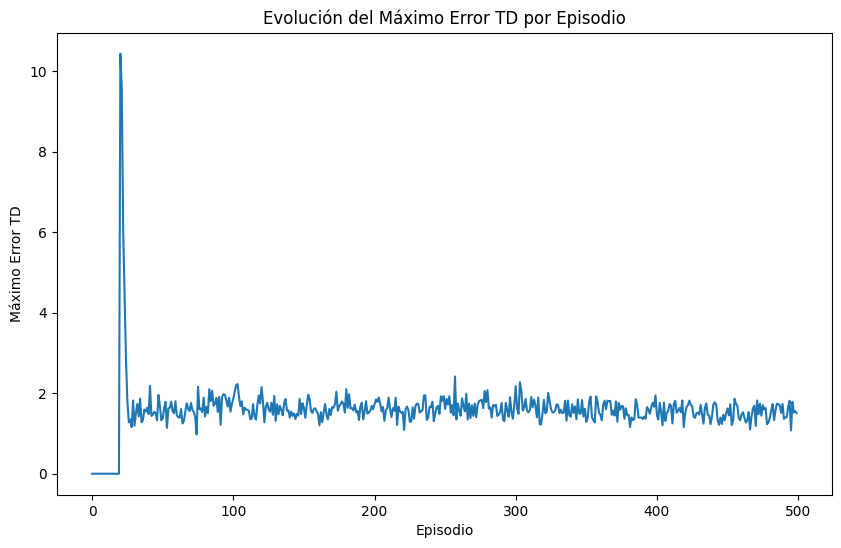

In [5]:
# Gráfico de la convergencia
plt.figure(figsize=(10, 6))
plt.plot(max_td_errors)
plt.xlabel('Episodio')
plt.ylabel('Máximo Error TD')
plt.title('Evolución del Máximo Error TD por Episodio')
plt.show()

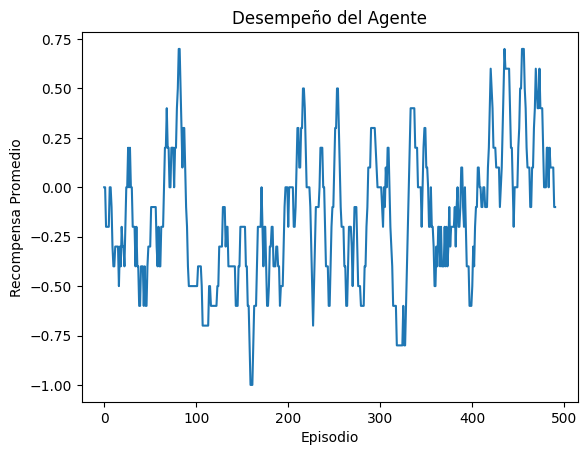

In [6]:
# Visualización de los resultados
plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'))
plt.title('Desempeño del Agente')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Promedio')
plt.show()

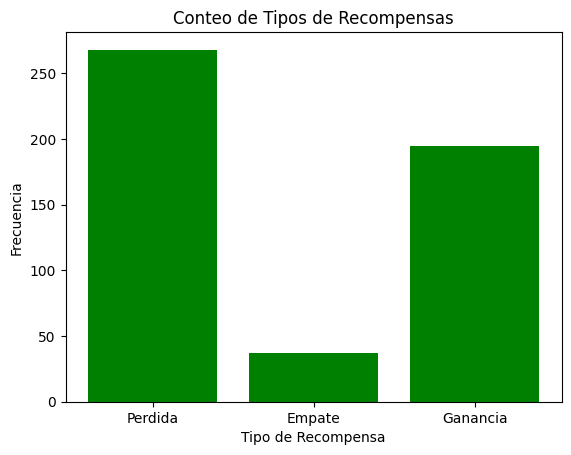

In [7]:
# Obtener los valores únicos y sus conteos
unique, counts = np.unique(rewards, return_counts=True)

# Crear el gráfico de barras
plt.bar(unique, counts, color='green', align='center')

# Configurar el título y las etiquetas del gráfico
plt.title('Conteo de Tipos de Recompensas')
plt.xlabel('Tipo de Recompensa')
plt.xticks(unique)
plt.xticks(unique, ['Perdida', 'Empate', 'Ganancia'])
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

In [9]:
rewards

[1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.

### DQN con técnicas de enriquecimiento de la representación de estados.

In [26]:
class DQNAgent2:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.rewards_history = []  # Historial de recompensas de las últimas manos
        self.gamma = 0.99  # slightly increased gamma for potentially better long-term rewards
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.005
        self.model = self._build_model()

    def _build_model(self):
        model = keras.Sequential([
            keras.layers.Dense(256, input_dim=4, activation='relu'),  # Adjusted input_dim to match the enriched state
            keras.layers.Dense(128, activation='relu'),  # Additional dense layer
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return env.action_space.sample()  # Exploration
        act_values = self.model.predict(np.array(state).reshape(1, -1))
        return np.argmax(act_values[0])  # Exploitation

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        max_td_error = 0  # Initialize max TD error for this batch
        for state, action, reward, next_state, done in minibatch:
            state = np.array(state).reshape(1, -1).astype('float32')
            next_state = np.array(next_state).reshape(1, -1).astype('float32')

            target = reward
            if not done:
                next_Q_values = self.model.predict(next_state)
                max_next_Q_values = np.amax(next_Q_values)
                target += self.gamma * max_next_Q_values  # Bellman equation update

            current_Q_values = self.model.predict(state)
            td_error = abs(current_Q_values[0][action] - target)
            max_td_error = max(max_td_error, td_error)  # Update max TD error

            current_Q_values[0][action] = target
            self.model.fit(state, current_Q_values, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return max_td_error

In [27]:
env = gym.make('Blackjack-v1', natural=False, sab=False)  # Ensure environment is properly set up
agent = DQNAgent2(state_size=4, action_size=2)  # state_size adjusted to match your enriched state

In [28]:
rewards2 = []
max_td_errors2 = []

episodes = 200  # Example number of episodes
batch_size = 32  # Example batch size

for e in range(episodes):
    initial_state, _ = env.reset()
    state = [initial_state[0], initial_state[1], 1 if initial_state[2] else 0, np.mean(agent.rewards_history[-10:]) if len(agent.rewards_history) > 10 else 0]  # Enriched state with average reward

    total_reward = 0
    max_episode_td_error = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = [next_state[0], next_state[1], 1 if next_state[2] else 0, np.mean(agent.rewards_history[-10:]) if len(agent.rewards_history) > 10 else 0]

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.rewards_history.append(reward)
        if len(agent.memory) > batch_size:
            max_td_error = agent.replay(batch_size)
            max_episode_td_error = max(max_episode_td_error, max_td_error)
        if done:
            break

    rewards2.append(total_reward)
    max_td_errors2.append(max_episode_td_error)
    print(f"Episode {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")

Episode 1/200, Score: -1.0, Epsilon: 1.00
Episode 2/200, Score: 1.0, Epsilon: 1.00
Episode 3/200, Score: -1.0, Epsilon: 1.00
Episode 4/200, Score: -1.0, Epsilon: 1.00
Episode 5/200, Score: 1.0, Epsilon: 1.00
Episode 6/200, Score: 0.0, Epsilon: 1.00
Episode 7/200, Score: -1.0, Epsilon: 1.00
Episode 8/200, Score: 1.0, Epsilon: 1.00
Episode 9/200, Score: -1.0, Epsilon: 1.00
Episode 10/200, Score: 1.0, Epsilon: 1.00
Episode 11/200, Score: -1.0, Epsilon: 1.00
Episode 12/200, Score: -1.0, Epsilon: 1.00
Episode 13/200, Score: -1.0, Epsilon: 1.00
Episode 14/200, Score: -1.0, Epsilon: 1.00
Episode 15/200, Score: -1.0, Epsilon: 1.00
Episode 16/200, Score: -1.0, Epsilon: 1.00
Episode 17/200, Score: -1.0, Epsilon: 1.00
Episode 18/200, Score: -1.0, Epsilon: 1.00
Episode 19/200, Score: -1.0, Epsilon: 1.00
Episode 20/200, Score: -1.0, Epsilon: 1.00
Episode 21/200, Score: 1.0, Epsilon: 1.00
Episode 22/200, Score: -1.0, Epsilon: 1.00
Episode 23/200, Score: -1.0, Epsilon: 1.00
Episode 24/200, Score: -1.

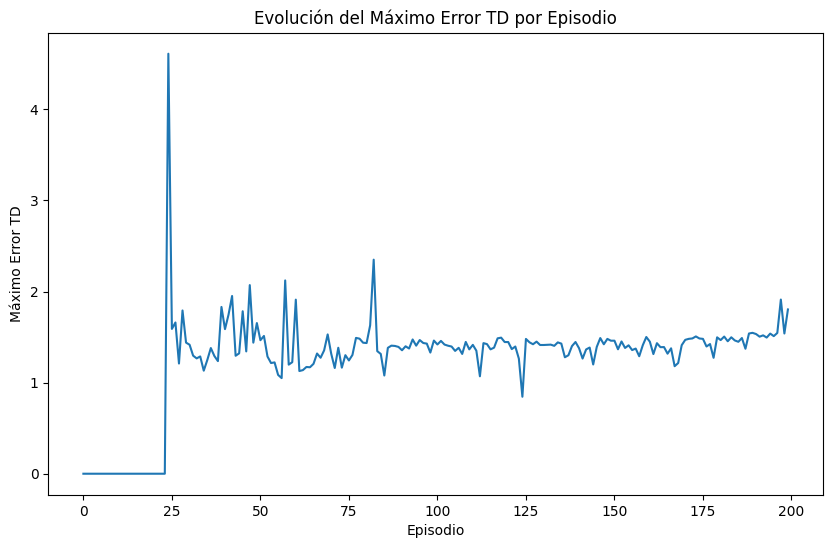

In [29]:
# Gráfico de la convergencia
plt.figure(figsize=(10, 6))
plt.plot(max_td_errors2)
plt.xlabel('Episodio')
plt.ylabel('Máximo Error TD')
plt.title('Evolución del Máximo Error TD por Episodio')
plt.show()

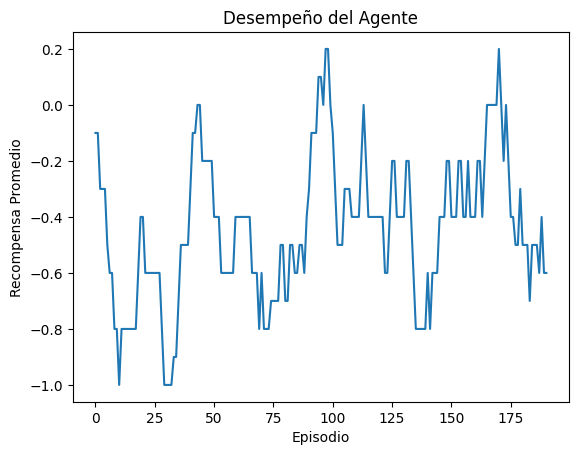

In [30]:
# Visualización de los resultados
plt.plot(np.convolve(rewards2, np.ones(10)/10, mode='valid'))
plt.title('Desempeño del Agente')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Promedio')
plt.show()

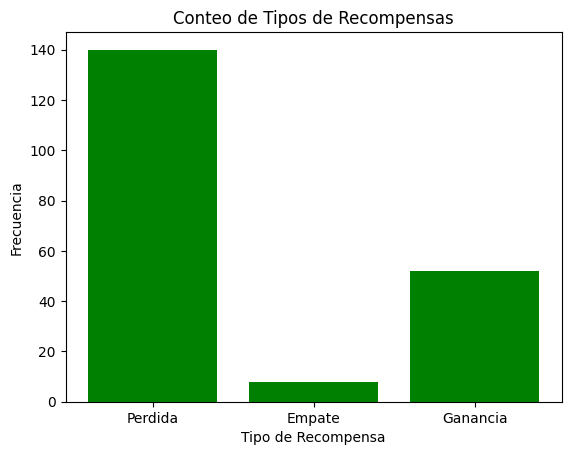

In [31]:
# Obtener los valores únicos y sus conteos
unique, counts = np.unique(rewards2, return_counts=True)

# Crear el gráfico de barras
plt.bar(unique, counts, color='green', align='center')

# Configurar el título y las etiquetas del gráfico
plt.title('Conteo de Tipos de Recompensas')
plt.xlabel('Tipo de Recompensa')
plt.xticks(unique)
plt.xticks(unique, ['Perdida', 'Empate', 'Ganancia'])
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

In [32]:
rewards2

[-1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 0.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,

# Comparación

In [39]:
def calculate_metrics(rewards):
    mean = np.mean(rewards)
    std = np.std(rewards)
    wins = np.sum(rewards > 0)
    losses = np.sum(rewards < 0)
    win_loss_ratio = wins / losses if losses != 0 else np.inf  # Avoid division by zero
    return mean, std, win_loss_ratio

In [41]:
rewards = np.array(rewards)  
rewards2 = np.array(rewards2)
rewards3 = np.array(rewards3)

In [49]:
# Calculate metrics for each set of rewards
metrics_dqn = calculate_metrics(rewards)
metrics_dqn_improved = calculate_metrics(rewards2)
metrics_ql = calculate_metrics(rewards3)

# Datos para la tabla
data = [
    ['DQN Básico', f"{metrics_dqn[0]:.2f}", f"{metrics_dqn[1]:.2f}", f"{metrics_dqn[2]:.2f}"],
    ['DQN Mejorado', f"{metrics_dqn_improved[0]:.2f}", f"{metrics_dqn_improved[1]:.2f}", f"{metrics_dqn_improved[2]:.2f}"],
    ['Q-Learning', f"{metrics_ql[0]:.2f}", f"{metrics_ql[1]:.2f}", f"{metrics_ql[2]:.2f}"]
]

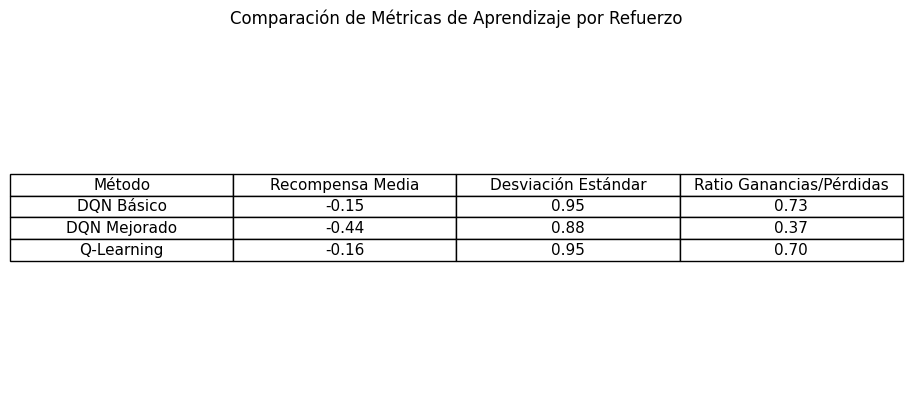

In [52]:
# Crear la figura y el eje para la tabla
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.set_title('Comparación de Métricas de Aprendizaje por Refuerzo')

# Crear la tabla
table = ax.table(cellText=data, colLabels=['Método', 'Recompensa Media', 'Desviación Estándar', 'Ratio Ganancias/Pérdidas'], loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.8, 1.3)  # Ajustar el tamaño de la tabla

plt.show()